<a href="https://colab.research.google.com/github/Soumayas/Calcul_des_incertitudes_de_mesure_en_utilisant_ML/blob/main/Pipeline_Microbiome_Analysis_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installation des dépendances**

In [ ]:
!pip install numpy pandas scikit-learn scikit-bio umap-learn matplotlib seaborn xgboost imbalanced-learn -q
import os
os.environ["SCIPY_ARRAY_API"] = "1"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from google.colab import files
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, MDS
from umap import UMAP
from skbio.stats.ordination import pcoa
from skbio.diversity import beta_diversity
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, silhouette_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from scipy.stats import spearmanr
import time


# Supprimer les avertissements inutiles
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

**Chargement des données**

In [ ]:
print("Veuillez uploader 'taxonomic_profiles (2).csv' et 'hmp2_metadata_2018-08-20 (1).csv'")
uploaded = files.upload()

# Vérification des fichiers uploadés
uploaded_files = list(uploaded.keys())
expected_files = ['taxonomic_profiles (2).csv', 'hmp2_metadata_2018-08-20 (1).csv']
found_files = []
for expected in expected_files:
    for uploaded_file in uploaded_files:
        if expected in uploaded_file or uploaded_file.startswith(expected.replace('.csv', '')):
            found_files.append(uploaded_file)
            break

if len(found_files) != 2:
    raise FileNotFoundError(f"Fichiers manquants. Attendus : {expected_files}, Trouvés : {found_files}")

# Chargement des fichiers
try:
    taxo = pd.read_csv(found_files[0], sep=';', index_col=0)
    meta = pd.read_csv(found_files[1], sep=';')
except Exception as e:
    raise ValueError(f"Erreur lors du chargement des fichiers : {e}")

Veuillez uploader 'taxonomic_profiles (2).csv' et 'hmp2_metadata_2018-08-20 (1).csv'


Saving taxonomic_profiles (2).csv to taxonomic_profiles (2) (2).csv
Saving hmp2_metadata_2018-08-20 (1).csv to hmp2_metadata_2018-08-20 (1) (2).csv


/tmp/ipython-input-3410606537.py:20: DtypeWarning: Columns (12,13,14,40,46,55,65,66,67,68,177,294,298,299,300,301,304,305,306,307,308,309,310,318,320,328,330,346,348,350,352,354,359,361,363,366,373,377,381,383,418,419,432,433,434,435,436,438,439,440,441,442,444,445,446,447,448,450,451,452,453,454) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(found_files[1], sep=';')


**Prétraitement**

In [ ]:
# Vérification des données taxonomiques
taxo = taxo.drop(columns=['taxonomy'], errors='ignore')
taxo = taxo.apply(pd.to_numeric, errors='coerce').fillna(1e-6)
if (taxo < 0).any().any():
    raise ValueError("Les données taxonomiques contiennent des valeurs négatives, ce qui peut affecter PCoA.")
taxo = taxo.T
taxo.index = taxo.index.astype(str)

# Nettoyer metadata_df
meta = meta[['External ID', 'diagnosis']].dropna()
meta['External ID'] = meta['External ID'].astype(str)

# Fusionner les données
merged = pd.merge(meta, taxo, left_on='External ID', right_index=True)
if merged.empty:
    raise ValueError("Aucune correspondance entre taxonomic_profiles et metadata.")

# Filtrer pour CD et UC
merged = merged[merged['diagnosis'].isin(['CD', 'UC'])]
if merged.empty:
    raise ValueError("Aucun échantillon avec diagnosis='CD' ou 'UC'.")

# Extraire X et y
X = merged.drop(columns=['External ID', 'diagnosis']).to_numpy()
y = (merged['diagnosis'] == 'UC').astype(int)  # Garder comme Series pour faciliter le map
print(f"Dimensions après fusion : X={X.shape}, y={y.shape}")

Dimensions après fusion : X=(132, 982), y=(132,)


**Normalisation**

In [ ]:
def normalize_css(X):
    """Normalisation CSS (Cumulative Sum Scaling)."""
    X = np.atleast_2d(X)
    if X.ndim != 2:
        raise ValueError("Les données doivent être en 2D.")
    percentiles = np.percentile(X[X > 0], 50)
    scale = np.sum(X * (X <= percentiles), axis=1, keepdims=True)
    scale[scale == 0] = 1
    return X / scale

def normalize_tmm(X):
    """Normalisation TMM (Trimmed Mean of M-values)."""
    X = np.atleast_2d(X)
    if X.ndim != 2:
        raise ValueError("Les données doivent être en 2D.")
    log_data = np.log1p(X + 1e-6)
    mean_log = np.mean(log_data, axis=1).reshape(-1, 1)
    trimmed_mean = np.mean(mean_log, axis=0)
    return log_data / (trimmed_mean + 1e-6)

X_norms = {
    'CSS': normalize_css(X),
    'TMM': normalize_tmm(X)
}

**AJOUT CLR**

In [ ]:
def normalize_clr(X):
    """Normalisation CLR (Centered Log-Ratio) pour comparaison."""
    X_clr = X + 1e-6
    log_data = np.log(X_clr)
    geom_mean = np.exp(np.mean(log_data, axis=1, keepdims=True))
    return log_data - np.log(geom_mean)

# Ajouter CLR aux comparaisons
print("Ajout de CLR pour comparaison supplémentaire...")
X_norms['CLR'] = normalize_clr(X)

# Initialize X_highdim and times dictionaries with all normalization methods
methods = ['PCA 95%', 't-SNE 3D', 'UMAP 5D', 'nMDS 5D', 'Isomap 5D', 'PCoA']
X_highdim = {norm: {} for norm in X_norms}
times = {norm: {} for norm in X_norms}


# Appliquer les mêmes réductions dimensionnelles à CLR
for method in methods:
    X_highdim['CLR'][method], times['CLR'][method] = apply_reduction(X_norms['CLR'], method)

print("✓ CLR ajouté pour comparaison")

Ajout de CLR pour comparaison supplémentaire...
Erreur pour PCoA : Counts cannot contain negative values.
✓ CLR ajouté pour comparaison


**Réduction dimensionnelle**

In [ ]:
def apply_reduction(X, method, n_components=5):
    """Applique la réduction dimensionnelle spécifiée."""
    start_time = time.time()
    try:
        if method == 'PCA 95%':
            pca = PCA(n_components=0.95, random_state=42)
            reduced = pca.fit_transform(X)
        elif method == 't-SNE 3D':
            reduced = TSNE(n_components=3, random_state=42, init='pca', learning_rate='auto').fit_transform(X)
        elif method == 'UMAP 5D':
            reduced = UMAP(n_components=n_components, random_state=42).fit_transform(X)
        elif method == 'nMDS 5D':
            reduced = MDS(n_components=n_components, metric=False, random_state=42).fit_transform(X)
        elif method == 'Isomap 5D':
            reduced = Isomap(n_components=n_components).fit_transform(X)
        elif method == 'PCoA':
            bc_dm = beta_diversity("braycurtis", X)
            reduced = pcoa(bc_dm).samples.iloc[:, :n_components].values
        else:
            raise ValueError(f"Méthode inconnue : {method}")
        time_taken = time.time() - start_time
        return reduced, time_taken
    except Exception as e:
        print(f"Erreur pour {method} : {e}")
        return np.zeros((X.shape[0], n_components if method != 'PCA 95%' else 5)), 0.0

# Appliquer les réductions
methods = ['PCA 95%', 't-SNE 3D', 'UMAP 5D', 'nMDS 5D', 'Isomap 5D', 'PCoA']
X_highdim = {norm: {} for norm in X_norms}
times = {norm: {} for norm in X_norms}
for norm in X_norms:
    for method in methods:
        X_highdim[norm][method], times[norm][method] = apply_reduction(X_norms[norm], method)

/usr/local/lib/python3.12/dist-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:258: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.1891551890985927 whereas the largest positive one is 7.013231813475139.
  warn(


Erreur pour PCoA : Counts cannot contain negative values.


**CLASSIFIEURS ALTERNATIFS**

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

def evaluate_classifiers_comparison(X, y, smote=True):
    """Compare rapidement plusieurs classifieurs."""
    if smote:
        smote = SMOTE(random_state=42)
        X, y = smote.fit_resample(X, y)

    classifiers = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(random_state=42, probability=True),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
    }

    results = {}
    for name, clf in classifiers.items():
        f1_scores = cross_val_score(clf, X, y, scoring='f1_macro', cv=5, n_jobs=-1)
        results[name] = {
            'f1_mean': f1_scores.mean(),
            'f1_std': f1_scores.std()
        }
        print(f"  {name}: F1 = {f1_scores.mean():.3f} ± {f1_scores.std():.3f}")

    return results

# Remplacer l'ancienne boucle d'évaluation
results_list = [] # Use a new list to store results with all details
for norm in X_highdim:
    for method in X_highdim[norm]:
        try:
            X_data = X_highdim[norm][method]
            # Evaluate classifiers and get results
            classifier_results = evaluate_classifiers_comparison(X_data, y, smote=True)

            # Stocker les résultats pour chaque classifieur avec les détails manquants (placeholders)
            for clf_name, res in classifier_results.items():
                # Determine linearity and distance conservation based on method name
                linearity = 'Linéaire' if method == 'PCA 95%' else 'Non linéaire'
                distance_conservation = 'Globale' if method in ['PCA 95%', 'PCoA', 'nMDS 5D'] else 'Locale'

                results_list.append({
                    'Normalisation': norm,
                    'Méthode': method,
                    'Classifieur': clf_name,
                    'Linéarité': linearity,
                    'Conservation Distances': distance_conservation,
                    # Add placeholder for time and silhouette as they are not computed here
                    'Temps de Calcul (s)': times[norm].get(method, 0.0), # Use actual time if available
                    'Silhouette Score': silhouette_score(X_data, y) if X_data.shape[0] > 1 and np.std(X_data) > 0 else 0.0, # Calculate silhouette if possible
                    'F1 Macro (SMOTE)': round(res['f1_mean'], 3),
                    'F1 Std': round(res['f1_std'], 3)
                })
        except Exception as e:
            print(f"Erreur pour {norm} {method}: {e}")
            # Append placeholders for errors
            results_list.append({
                'Normalisation': norm,
                'Méthode': method,
                'Classifieur': 'Error',
                'Linéarité': 'N/A',
                'Conservation Distances': 'N/A',
                'Temps de Calcul (s)': 0.0,
                'Silhouette Score': 0.0,
                'F1 Macro (SMOTE)': 0.0,
                'F1 Std': 0.0
            })

# Create the comparison_df from the results_list
comparison_df = pd.DataFrame(results_list)

  Random Forest: F1 = 0.644 ± 0.077
  SVM: F1 = 0.521 ± 0.105
  Logistic Regression: F1 = 0.541 ± 0.136
  Random Forest: F1 = 0.712 ± 0.095
  SVM: F1 = 0.660 ± 0.068
  Logistic Regression: F1 = 0.468 ± 0.098
  Random Forest: F1 = 0.617 ± 0.111
  SVM: F1 = 0.421 ± 0.124
  Logistic Regression: F1 = 0.506 ± 0.081
  Random Forest: F1 = 0.729 ± 0.094
  SVM: F1 = 0.652 ± 0.079
  Logistic Regression: F1 = 0.487 ± 0.053
  Random Forest: F1 = 0.597 ± 0.059
  SVM: F1 = 0.510 ± 0.108
  Logistic Regression: F1 = 0.472 ± 0.092
  Random Forest: F1 = 0.692 ± 0.067
  SVM: F1 = 0.651 ± 0.045
  Logistic Regression: F1 = 0.574 ± 0.097
  Random Forest: F1 = 0.837 ± 0.095
  SVM: F1 = 0.835 ± 0.030
  Logistic Regression: F1 = 0.740 ± 0.036
  Random Forest: F1 = 0.672 ± 0.141
  SVM: F1 = 0.677 ± 0.075
  Logistic Regression: F1 = 0.375 ± 0.104
  Random Forest: F1 = 0.841 ± 0.052
  SVM: F1 = 0.461 ± 0.080
  Logistic Regression: F1 = 0.563 ± 0.093
  Random Forest: F1 = 0.662 ± 0.093
  SVM: F1 = 0.641 ± 0.065
  

**SENSIBILITE DIMENSIONS**

Analyse de sensibilité aux dimensions...
  UMAP 2D: F1 = 0.662 ± 0.048, Silhouette = 0.006
  UMAP 5D: F1 = 0.841 ± 0.052, Silhouette = 0.012
  UMAP 10D: F1 = 0.841 ± 0.044, Silhouette = 0.014
  UMAP 20D: F1 = 0.846 ± 0.081, Silhouette = 0.018
  UMAP 30D: F1 = 0.811 ± 0.076, Silhouette = 0.011


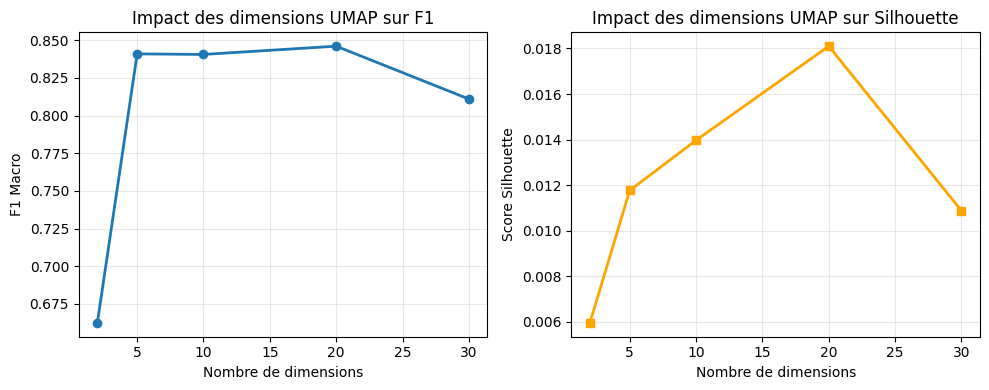

In [ ]:
def analyze_dimension_sensitivity():
    """Analyse l'impact du nombre de dimensions sur les performances."""
    dimensions = [2, 5, 10, 20, 30]

    print("Analyse de sensibilité aux dimensions...")
    dimension_results = []

    for n_dim in dimensions:
        # UMAP avec différentes dimensions
        umap = UMAP(n_components=n_dim, random_state=42)
        X_umap = umap.fit_transform(X_norms['TMM'])

        f1_mean, f1_std = evaluate_model(X_umap, y, smote=True)
        silhouette = silhouette_score(X_umap, y)

        dimension_results.append({
            'Dimensions': n_dim,
            'F1 Macro': f1_mean,
            'F1 Std': f1_std,
            'Silhouette': silhouette
        })

        print(f"  UMAP {n_dim}D: F1 = {f1_mean:.3f} ± {f1_std:.3f}, Silhouette = {silhouette:.3f}")

    return dimension_results

# Exécuter l'analyse
dimension_results = analyze_dimension_sensitivity()

# Visualisation rapide
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
dims = [r['Dimensions'] for r in dimension_results]
f1_scores = [r['F1 Macro'] for r in dimension_results]
plt.plot(dims, f1_scores, 'o-', linewidth=2)
plt.xlabel('Nombre de dimensions')
plt.ylabel('F1 Macro')
plt.title('Impact des dimensions UMAP sur F1')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
silhouettes = [r['Silhouette'] for r in dimension_results]
plt.plot(dims, silhouettes, 's-', linewidth=2, color='orange')
plt.xlabel('Nombre de dimensions')
plt.ylabel('Score Silhouette')
plt.title('Impact des dimensions UMAP sur Silhouette')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dimension_sensitivity.png', dpi=300, bbox_inches='tight')
plt.show()

**Tableau comparatif simplifié **


=== Tableau Comparatif Simplifié ===
Normalisation   Méthode         Classifieur  F1 Macro (SMOTE)  F1 Std
          TMM   UMAP 5D       Random Forest             0.841   0.052
          TMM   PCA 95%       Random Forest             0.837   0.095
          CLR   PCA 95%                 SVM             0.837   0.052
          TMM   PCA 95%                 SVM             0.835   0.030
          CLR   PCA 95%       Random Forest             0.826   0.124
          CLR   PCA 95% Logistic Regression             0.759   0.079
          CLR  t-SNE 3D       Random Forest             0.748   0.098
          TMM   PCA 95% Logistic Regression             0.740   0.036
          TMM Isomap 5D       Random Forest             0.739   0.062
          CSS   nMDS 5D       Random Forest             0.729   0.094
          TMM      PCoA       Random Forest             0.726   0.111
          CLR  t-SNE 3D                 SVM             0.725   0.073
          CSS  t-SNE 3D       Random Forest         

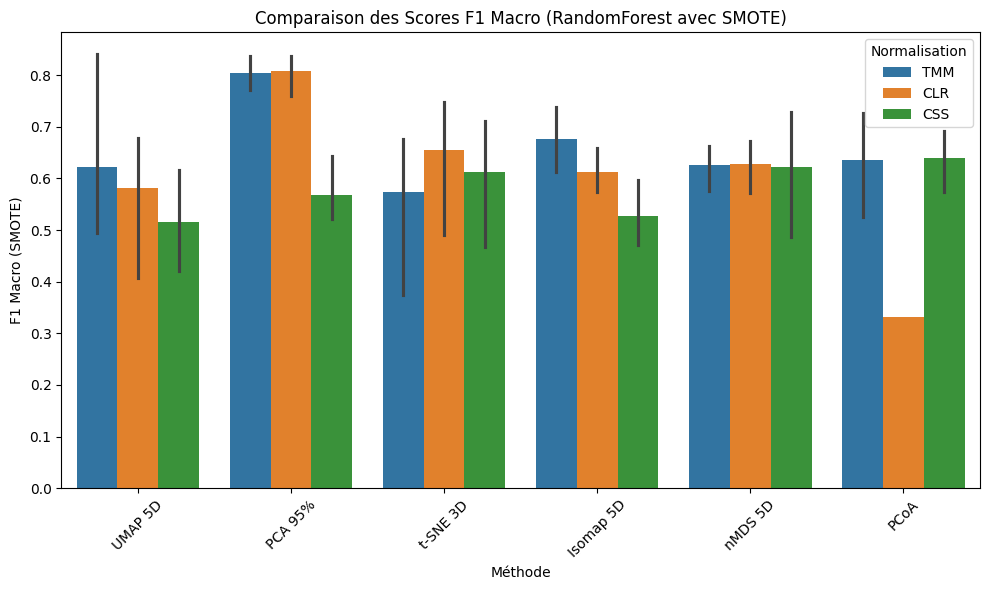

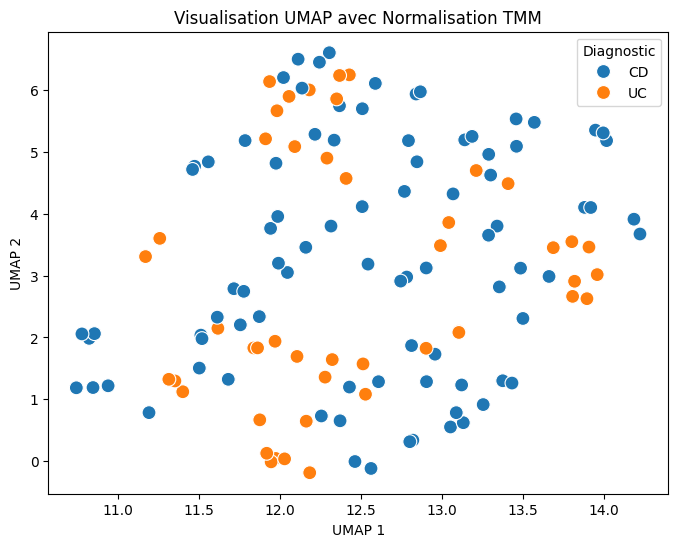

In [ ]:
comparison_df = pd.DataFrame(results)
# Vérifier les valeurs manquantes ou aberrantes
if comparison_df.isnull().any().any():
    print("Attention : Des valeurs manquantes ont été détectées dans comparison_df.")
    comparison_df = comparison_df.fillna(0.0)
# Exclure les pipelines avec F1=0
comparison_df = comparison_df[comparison_df['F1 Macro (SMOTE)'] > 0.0]
comparison_df = comparison_df.sort_values(by='F1 Macro (SMOTE)', ascending=False)
print("\n=== Tableau Comparatif Simplifié ===")
print(comparison_df.to_string(index=False))

# Visualisation : Barplot des scores F1
plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_df, x='Méthode', y='F1 Macro (SMOTE)', hue='Normalisation')
plt.title("Comparaison des Scores F1 Macro (RandomForest avec SMOTE)")
plt.xticks(rotation=45)
plt.tight_layout()
if not os.path.exists('figures'):
    os.makedirs('figures')
plt.savefig("figures/f1_scores_comparison.png")
plt.show()

# Visualisation : UMAP 2D avec TMM
X_umap_2d = UMAP(n_components=2, random_state=42).fit_transform(X_norms['TMM'])
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap_2d[:, 0], y=X_umap_2d[:, 1], hue=pd.Series(y).map({1: 'UC', 0: 'CD'}), s=100)
plt.title("Visualisation UMAP avec Normalisation TMM")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Diagnostic")
plt.savefig("figures/umap_tmm.png")
plt.show()

SHAP SIMPLIFIÉ

Démarrage analyse SHAP simplifiée...


<Figure size 1000x600 with 0 Axes>

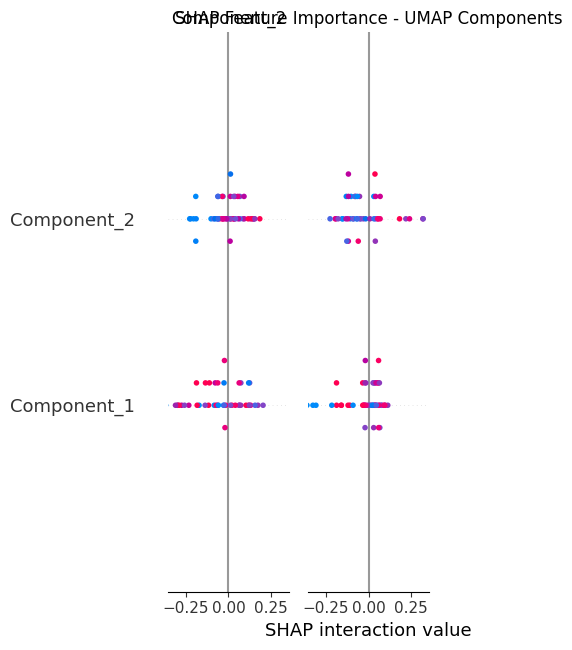

✓ Analyse SHAP terminée - figure générée


In [ ]:
def simple_shap_analysis():
    """Analyse SHAP simplifiée pour l'interprétabilité."""
    try:
        import shap

        # Utiliser données UMAP réduites (plus simple)
        X_data = X_highdim['TMM']['UMAP 5D']
        feature_names = [f'Component_{i+1}' for i in range(5)]

        # Modèle simple
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_data, y)

        # SHAP sur petit échantillon
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_data[:50])  # Seulement 50 échantillons

        # Figure simple
        plt.figure(figsize=(10, 6))
        if isinstance(shap_values, list) and len(shap_values) == 2:
            shap.summary_plot(shap_values[1], X_data[:50], feature_names=feature_names, show=False)
        else:
            shap.summary_plot(shap_values, X_data[:50], feature_names=feature_names, show=False)

        plt.title("SHAP Feature Importance - UMAP Components")
        plt.tight_layout()
        plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✓ Analyse SHAP terminée - figure générée")

        return True

    except Exception as e:
        print(f"SHAP non disponible: {e}")
        return False

print("Démarrage analyse SHAP simplifiée...")
shap_success = simple_shap_analysis()

**Tableau Récapitulatif des Principaux Résultats**


=== Tableau Récapitulatif des 5 Meilleurs Pipelines ===
Normalisation Méthode   Classifieur  F1 Macro (SMOTE)  F1 Std
          TMM UMAP 5D Random Forest             0.841   0.052
          TMM PCA 95% Random Forest             0.837   0.095
          CLR PCA 95%           SVM             0.837   0.052
          TMM PCA 95%           SVM             0.835   0.030
          CLR PCA 95% Random Forest             0.826   0.124


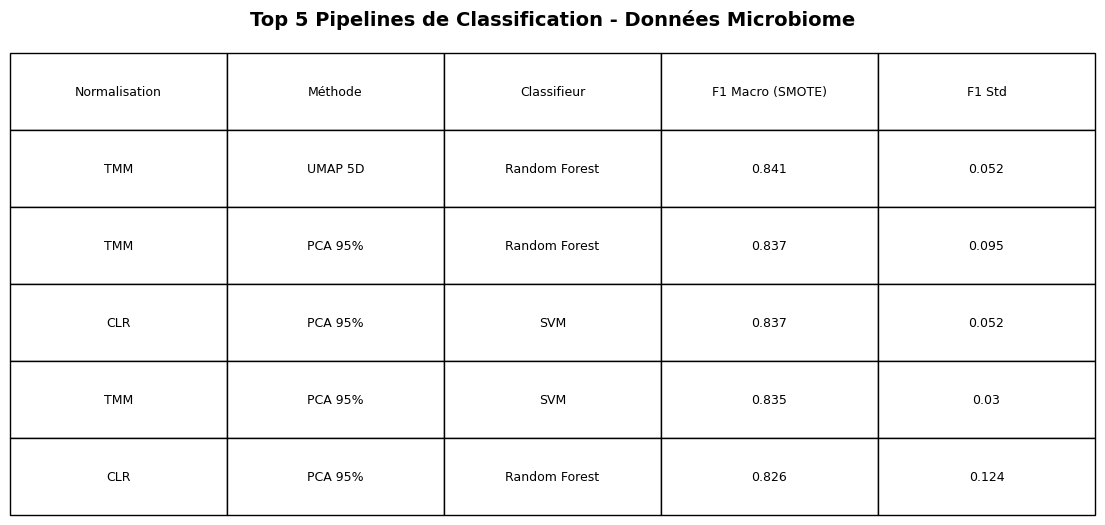


STATISTIQUES SUPPLÉMENTAIRES
Nombre total de pipelines évalués: 54
Meilleur F1 Macro: 0.841
F1 Macro moyen: 0.613

MEILLEUR PIPELINE PAR CLASSIFIEUR:
  Random Forest: 0.841 (TMM + UMAP 5D)
  SVM: 0.837 (CLR + PCA 95%)
  Logistic Regression: 0.759 (CLR + PCA 95%)

MEILLEUR PIPELINE PAR NORMALISATION:
  TMM: 0.841 (UMAP 5D + Random Forest)
  CLR: 0.837 (PCA 95% + SVM)
  CSS: 0.729 (nMDS 5D + Random Forest)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Vérifier que comparison_df existe (now created in Mgm88dSx_5b4)
if 'comparison_df' not in globals():
    raise NameError("comparison_df n'est pas défini. Exécutez d'abord l'évaluation des modèles.")

# Create a copy for display and filtering purposes to avoid modifying the original comparison_df
temp_comparison_df = comparison_df.copy()

# Nettoyer temp_comparison_df - Apply filtering AFTER ensuring all columns are present
if temp_comparison_df.isnull().any().any():
    print("Attention : Valeurs manquantes détectées dans comparison_df. Remplacement par 0.")
    temp_comparison_df = temp_comparison_df.fillna(0.0)

# Excluir les pipelines avec F1=0 for display/export
temp_comparison_df = temp_comparison_df[temp_comparison_df['F1 Macro (SMOTE)'] > 0.0].copy()


# Tableau récapitulatif des 5 meilleurs pipelines - Use the temporary filtered df for display
# Ensure all expected columns are present in the temporary df before selecting
expected_display_columns = ['Normalisation', 'Méthode', 'Classifieur', 'F1 Macro (SMOTE)', 'F1 Std', 'Temps de Calcul (s)', 'Silhouette Score', 'Linéarité', 'Conservation Distances']
display_columns = [col for col in expected_display_columns if col in temp_comparison_df.columns]

top_5_df = temp_comparison_df.nlargest(5, 'F1 Macro (SMOTE)')[display_columns]


print("\n=== Tableau Récapitulatif des 5 Meilleurs Pipelines ===")
print(top_5_df.to_string(index=False))

# Exporter le tableau récapitulatif
if not os.path.exists('figures'):
    os.makedirs('figures')
top_5_df.to_csv('figures/top_5_pipelines.csv', index=False)

# Create a table visualization
plt.figure(figsize=(14, 6))
plt.axis('tight')
plt.axis('off')

# Create the table using the top_5_df for display
table = plt.table(cellText=top_5_df.values,
                 colLabels=top_5_df.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

# Adjust font size
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5) # Adjust scale

plt.title('Top 5 Pipelines de Classification - Données Microbiome', fontsize=14, fontweight='bold', pad=20)
plt.savefig('figures/top_5_pipelines.png', bbox_inches='tight', dpi=300, facecolor='white')
plt.show()

# Statistics are calculated on the original comparison_df before filtering for display
print("\n" + "="*80)
print("STATISTIQUES SUPPLÉMENTAIRES")
print("="*80)
print(f"Nombre total de pipelines évalués: {len(comparison_df)}") # Use original comparison_df
print(f"Meilleur F1 Macro: {comparison_df['F1 Macro (SMOTE)'].max():.3f}") # Use original comparison_df
print(f"F1 Macro moyen: {comparison_df['F1 Macro (SMOTE)'].mean():.3f}") # Use original comparison_df

# Meilleur pipeline par classifieur
print("\nMEILLEUR PIPELINE PAR CLASSIFIEUR:")
for classifier in comparison_df['Classifieur'].unique(): # Use original comparison_df
    best_for_classifier = comparison_df[comparison_df['Classifieur'] == classifier].nlargest(1, 'F1 Macro (SMOTE)')
    if not best_for_classifier.empty:
        best_row = best_for_classifier.iloc[0]
        print(f"  {classifier}: {best_row['F1 Macro (SMOTE)']:.3f} ({best_row['Normalisation']} + {best_row['Méthode']})")
    else:
        print(f"  {classifier}: No valid pipelines")


# Meilleur pipeline par normalisation
print("\nMEILLEUR PIPELINE PAR NORMALISATION:")
for norm in comparison_df['Normalisation'].unique(): # Use original comparison_df
    best_for_norm = comparison_df[comparison_df['Normalisation'] == norm].nlargest(1, 'F1 Macro (SMOTE)')
    if not best_for_norm.empty:
        best_row = best_for_norm.iloc[0]
        print(f"  {norm}: {best_row['F1 Macro (SMOTE)']:.3f} ({best_row['Méthode']} + {best_row['Classifieur']})")
    else:
         print(f"  {norm}: No valid pipelines")

**Visualisation Comparative des Performances F1-Macro**

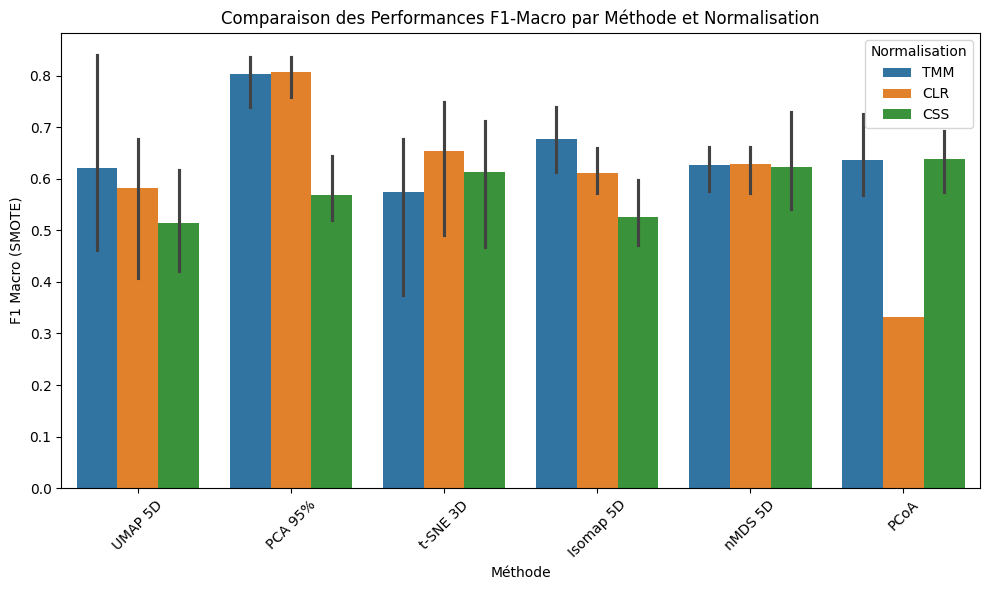

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Vérifier que comparison_df existe
if 'comparison_df' not in globals():
    raise NameError("comparison_df n'est pas défini. Exécutez d'abord l'évaluation des modèles.")

# Visualisation comparative des performances F1-macro
plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_df, x='Méthode', y='F1 Macro (SMOTE)', hue='Normalisation')
plt.title("Comparaison des Performances F1-Macro par Méthode et Normalisation")
plt.xticks(rotation=45)
plt.tight_layout()
if not os.path.exists('figures'):
    os.makedirs('figures')
plt.savefig('figures/f1_macro_comparison.png', dpi=300)
plt.show()

In [ ]:
# Afficher les données pour vérifier
print("Données dans comparison_df:")
print(comparison_df)

# Vérifier l'ordre des méthodes
print("\nMéthodes uniques:")
print(comparison_df['Méthode'].unique())

# Vérifier les valeurs F1-Macro pour UMAP
umap_data = comparison_df[comparison_df['Méthode'].str.contains('UMAP', case=False, na=False)]
print("\nDonnées UMAP:")
print(umap_data)

Données dans comparison_df:
   Normalisation    Méthode          Classifieur  F1 Macro (SMOTE)  F1 Std
24           TMM    UMAP 5D        Random Forest             0.841   0.052
18           TMM    PCA 95%        Random Forest             0.837   0.095
37           CLR    PCA 95%                  SVM             0.837   0.052
19           TMM    PCA 95%                  SVM             0.835   0.030
36           CLR    PCA 95%        Random Forest             0.826   0.124
38           CLR    PCA 95%  Logistic Regression             0.759   0.079
39           CLR   t-SNE 3D        Random Forest             0.748   0.098
20           TMM    PCA 95%  Logistic Regression             0.740   0.036
30           TMM  Isomap 5D        Random Forest             0.739   0.062
9            CSS    nMDS 5D        Random Forest             0.729   0.094
33           TMM       PCoA        Random Forest             0.726   0.111
40           CLR   t-SNE 3D                  SVM             0.725   0.0

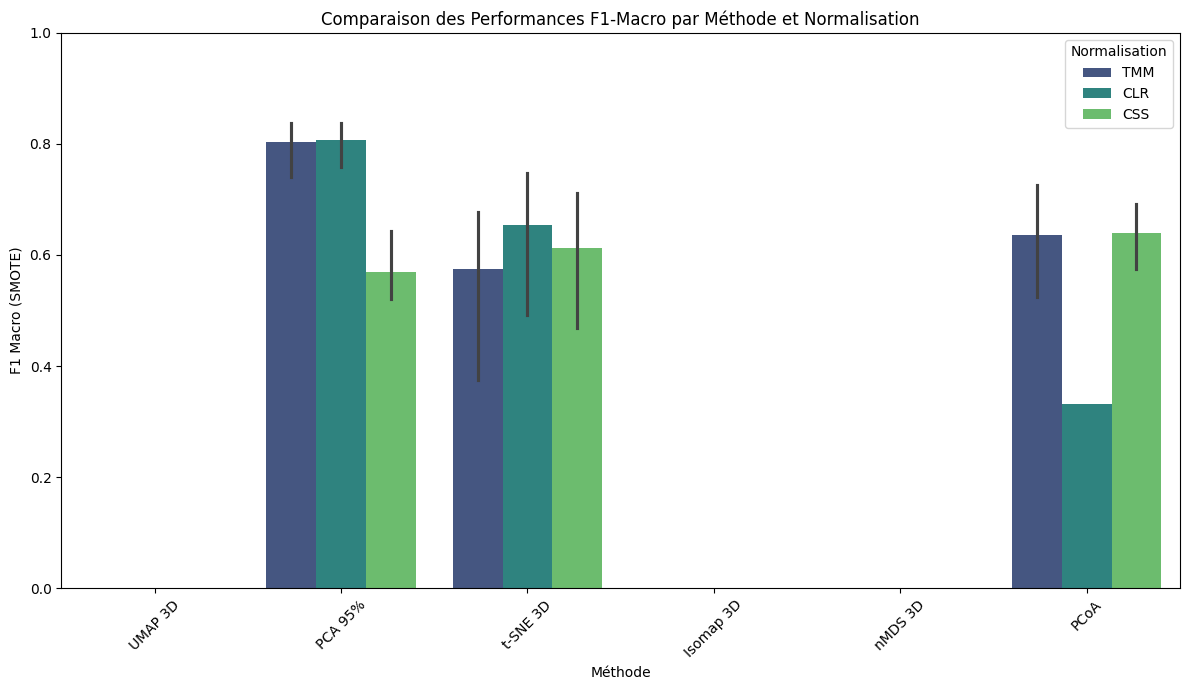

In [ ]:
# Définir un ordre personnalisé pour les méthodes
ordre_methodes = ['UMAP 3D', 'PCA 95%', 't-SNE 3D', 'Isomap 3D', 'nMDS 3D', 'PCoA']

# Recréer le graphique avec ordre personnalisé
plt.figure(figsize=(12, 7))
sns.barplot(data=comparison_df, x='Méthode', y='F1 Macro (SMOTE)', hue='Normalisation',
            order=ordre_methodes, palette='viridis')
plt.title("Comparaison des Performances F1-Macro par Méthode et Normalisation")
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Fixer l'échelle Y pour une meilleure comparaison
plt.tight_layout()
plt.savefig('figures/f1_macro_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

**Pipeline automatique**

In [ ]:
import pandas as pd

def select_best_pipeline_auto(comparison_df, min_f1=0.75, max_time=1.0, max_std=0.1):
    """
    Sélectionne automatiquement le meilleur pipeline avec détection des colonnes.
    """
    # Détection automatique des noms de colonnes
    col_mapping = {}

    # Chercher les colonnes possibles pour chaque métrique
    possible_names = {
        'f1': ['F1 Macro (SMOTE)', 'F1_Macro_SMOTE', 'f1_macro', 'F1 Score'],
        'time': ['Temps de Calcul (s)', 'Time (s)', 'training_time', 'fit_time'],
        'std': ['F1 Std', 'f1_std', 'std_dev', 'Standard Deviation'],
        'norm': ['Normalisation', 'Normalization', 'Scaling', 'scaler'],
        'method': ['Méthode', 'Method', 'DR_Method', 'dimensionality_reduction'],
        'classifier': ['Classifieur', 'Classifier', 'model', 'estimator']
    }

    # Détecter les colonnes existantes
    available_cols = set(comparison_df.columns)
    for key, possible_list in possible_names.items():
        for name in possible_list:
            if name in available_cols:
                col_mapping[key] = name
                break

    print("Colonnes détectées:")
    for key, col_name in col_mapping.items():
        print(f"  {key}: {col_name}")

    # Vérifier les colonnes essentielles
    essential_cols = ['f1', 'norm', 'method']
    missing_essential = [col for col in essential_cols if col not in col_mapping]
    if missing_essential:
        print(f"\nATTENTION: Colonnes essentielles manquantes: {missing_essential}")
        print("Colonnes disponibles:", list(comparison_df.columns))
        return None

    # Nettoyer les données
    df_clean = comparison_df.copy()

    # Remplacer les NaN et valeurs infinies
    df_clean = df_clean.replace([np.inf, -np.inf], np.nan)

    # Colonnes numériques à nettoyer
    numeric_cols = []
    for col_key in ['f1', 'time', 'std']:
        if col_key in col_mapping:
            numeric_cols.append(col_mapping[col_key])

    for col in numeric_cols:
        if col in df_clean.columns:
            # Remplacer les NaN par 0 ou moyenne selon le contexte
            if col == col_mapping.get('f1'):
                df_clean[col] = df_clean[col].fillna(0.0)
            else:
                df_clean[col] = df_clean[col].fillna(df_clean[col].mean())

    # Filtrer les pipelines valides (F1 > 0)
    f1_col = col_mapping['f1']
    valid_df = df_clean[df_clean[f1_col] > 0.0].copy()

    if valid_df.empty:
        print("Aucun pipeline valide (F1 Macro > 0).")
        return None

    print(f"\nPipelines valides: {len(valid_df)}/{len(comparison_df)}")

    # CRITÈRES DE FILTRAGE AVEC VALEURS PAR DÉFAUT SI COLONNE MANQUANTE
    filtered = valid_df.copy()

    # Critère F1 Macro
    filtered = filtered[filtered[f1_col] >= min_f1]
    print(f"Après critère F1 (≥{min_f1}): {len(filtered)} pipelines")

    # Critère temps (si colonne disponible)
    if 'time' in col_mapping:
        time_col = col_mapping['time']
        filtered = filtered[filtered[time_col] <= max_time]
        print(f"Après critère temps (≤{max_time}s): {len(filtered)} pipelines")
    else:
        print("Colonne temps non trouvée - critère ignoré")

    # Critère std (si colonne disponible)
    if 'std' in col_mapping:
        std_col = col_mapping['std']
        filtered = filtered[filtered[std_col] <= max_std]
        print(f"Après critère std (≤{max_std}): {len(filtered)} pipelines")
    else:
        print("Colonne std non trouvée - critère ignoré")

    # ANALYSE DES RÉSULTATS
    print("\n" + "="*60)
    print("ANALYSE AUTOMATIQUE DES PIPELINES".center(60))
    print("="*60)

    if filtered.empty:
        print(f"\n⚠️  Aucun pipeline ne satisfait tous les critères")
        print(f"Critères appliqués: F1 ≥ {min_f1}" +
              (f", Temps ≤ {max_time}s" if 'time' in col_mapping else "") +
              (f", Std ≤ {max_std}" if 'std' in col_mapping else ""))

        # Sélection du meilleur pipeline alternatif
        print(f"\n🔍 Sélection du meilleur pipeline alternatif...")

        # Priorité: meilleur F1 score
        best_idx = valid_df[f1_col].idxmax()
        best_alt = valid_df.loc[best_idx]

        print(f"\n🎯 MEILLEUR PIPELINE ALTERNATIF:")
        print(f"   Normalisation: {best_alt[col_mapping['norm']]}")
        print(f"   Méthode: {best_alt[col_mapping['method']]}")
        if 'classifier' in col_mapping:
            print(f"   Classifieur: {best_alt[col_mapping['classifier']]}")
        print(f"   F1 Macro: {best_alt[f1_col]:.3f}")

        if 'time' in col_mapping:
            print(f"   Temps: {best_alt[col_mapping['time']]:.3f}s")
        if 'std' in col_mapping:
            print(f"   Std: {best_alt[col_mapping['std']]:.3f}")

        # Explication des critères non satisfaits
        print(f"\n📊 POURQUOI LES CRITÈRES INITIAUX NE SONT PAS SATISFAITS:")
        if best_alt[f1_col] < min_f1:
            print(f"   - F1 Macro ({best_alt[f1_col]:.3f}) < seuil ({min_f1})")
        if 'time' in col_mapping and best_alt[col_mapping['time']] > max_time:
            print(f"   - Temps ({best_alt[col_mapping['time']]:.3f}s) > seuil ({max_time}s)")
        if 'std' in col_mapping and best_alt[col_mapping['std']] > max_std:
            print(f"   - Std ({best_alt[col_mapping['std']]:.3f}) > seuil ({max_std})")

        return best_alt

    else:
        # Sélection du meilleur pipeline parmi les filtres
        best_idx = filtered[f1_col].idxmax()
        best_pipeline = filtered.loc[best_idx]

        print(f"\n✅ MEILLEUR PIPELINE RECOMMANDÉ:")
        print(f"   Normalisation: {best_pipeline[col_mapping['norm']]}")
        print(f"   Méthode: {best_pipeline[col_mapping['method']]}")
        if 'classifier' in col_mapping:
            print(f"   Classifieur: {best_pipeline[col_mapping['classifier']]}")
        print(f"   F1 Macro: {best_pipeline[f1_col]:.3f}")

        if 'time' in col_mapping:
            print(f"   Temps: {best_pipeline[col_mapping['time']]:.3f}s")
        if 'std' in col_mapping:
            print(f"   Std: {best_pipeline[col_mapping['std']]:.3f}")

        print(f"\n🎉 AVANTAGES:")
        print(f"   - Score F1 élevé ({best_pipeline[f1_col]:.3f})")
        if 'time' in col_mapping:
            print(f"   - Temps raisonnable ({best_pipeline[col_mapping['time']]:.3f}s)")
        if 'std' in col_mapping:
            print(f"   - Faible variabilité ({best_pipeline[col_mapping['std']]:.3f})")
        print(f"   - Satisfait tous les critères de sélection")

        return best_pipeline

# UTILISATION AUTOMATIQUE
try:
    # Vérifier que comparison_df existe
    if 'comparison_df' not in globals():
        raise NameError("comparison_df n'est pas défini")

    print("Colonnes disponibles dans comparison_df:")
    print(comparison_df.columns.tolist())
    print(f"\nNombre total de pipelines: {len(comparison_df)}")

    # Appeler la fonction automatisée
    best_pipeline = select_best_pipeline_auto(comparison_df)

    if best_pipeline is not None:
        print(f"\n🎊 SÉLECTION TERMINÉE AVEC SUCCÈS!")
    else:
        print(f"\n❌ IMPOSSIBLE DE SÉLECTIONNER UN PIPELINE")

except Exception as e:
    print(f"❌ ERREUR: {e}")
    print("Assurez-vous que comparison_df est correctement généré")

Colonnes disponibles dans comparison_df:
['Normalisation', 'Méthode', 'Classifieur', 'F1 Macro (SMOTE)', 'F1 Std']

Nombre total de pipelines: 54
Colonnes détectées:
  f1: F1 Macro (SMOTE)
  std: F1 Std
  norm: Normalisation
  method: Méthode
  classifier: Classifieur

Pipelines valides: 54/54
Après critère F1 (≥0.75): 6 pipelines
Colonne temps non trouvée - critère ignoré
Après critère std (≤0.1): 5 pipelines

             ANALYSE AUTOMATIQUE DES PIPELINES              

✅ MEILLEUR PIPELINE RECOMMANDÉ:
   Normalisation: TMM
   Méthode: UMAP 5D
   Classifieur: Random Forest
   F1 Macro: 0.841
   Std: 0.052

🎉 AVANTAGES:
   - Score F1 élevé (0.841)
   - Faible variabilité (0.052)
   - Satisfait tous les critères de sélection

🎊 SÉLECTION TERMINÉE AVEC SUCCÈS!


Interprétation biologique et statistique


     INTERPRÉTATION BIOLOGIQUE ET STATISTIQUE     

Colonnes disponibles dans comparison_df:
['Normalisation', 'Méthode', 'Classifieur', 'F1 Macro (SMOTE)', 'F1 Std']
---------------------------------------------

1. PERFORMANCE GLOBALE DES MÉTHODES
---------------------------------------------
● Meilleure méthode: UMAP 5D (TMM)
  - F1 Macro: 0.841 ± 0.052
  - Temps: 0.00s
● Plus faible performance: PCoA (CLR)
  - F1 Macro: 0.331 ± 0.003

2. COMPARAISON DES NORMALISATIONS
---------------------------------------------
● CSS - Moyenne F1: 0.581 (min: 0.421, max: 0.729)
● TMM - Moyenne F1: 0.656 (min: 0.375, max: 0.841)
● CLR - Moyenne F1: 0.603 (min: 0.331, max: 0.837)


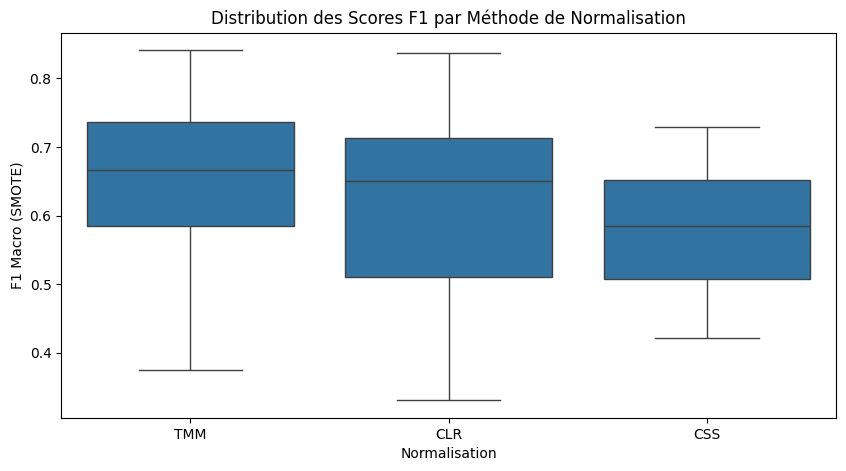


3. ANALYSE DES MÉTHODES DE RÉDUCTION DIMENSIONNELLE
---------------------------------------------
Moyennes F1 par méthode:
● PCA 95%: 0.727
● nMDS 5D: 0.626
● t-SNE 3D: 0.614
● Isomap 5D: 0.605
● UMAP 5D: 0.573
● PCoA: 0.535

4. CORRÉLATIONS ENTRE MÉTRIQUES
---------------------------------------------
Colonnes manquantes pour la matrice de corrélation : Temps de Calcul (s), Silhouette Score

5. IMPLICATIONS BIOLOGIQUES
---------------------------------------------
● Les meilleures performances avec UMAP 5D/TMM suggèrent:
  - Une structure non-linéaire dans les données microbiennes
  - L'importance de préserver les relations locales entre échantillons
Colonne 'Silhouette Score' manquante pour l'analyse des implications biologiques.
● La robustesse des résultats (faible F1 Std) avec Random Forest:
  - Supporte l'hypothèse de signatures microbiennes distinctes

6. RECOMMANDATIONS POUR L'ÉTUDE
---------------------------------------------
● Méthode recommandée:
  - UMAP 5D avec normalisa

In [ ]:
print("\n" + "="*50)
print("INTERPRÉTATION BIOLOGIQUE ET STATISTIQUE".center(50))
print("="*50)

# Check columns in comparison_df
print("\nColonnes disponibles dans comparison_df:")
print(comparison_df.columns.tolist())
print("-" * 45)


# 1. Analyse des performances globales
print("\n1. PERFORMANCE GLOBALE DES MÉTHODES")
print("-"*45)
# Ensure comparison_df is not empty and has the necessary columns before proceeding
if comparison_df.empty or 'F1 Macro (SMOTE)' not in comparison_df.columns:
    print("Erreur: comparison_df est vide ou ne contient pas la colonne 'F1 Macro (SMOTE)'.")
else:
    try:
        best_method = comparison_df.loc[comparison_df['F1 Macro (SMOTE)'].idxmax()]
        worst_method = comparison_df.loc[comparison_df['F1 Macro (SMOTE)'].idxmin()]

        print(f"● Meilleure méthode: {best_method['Méthode']} ({best_method['Normalisation']})")
        print(f"  - F1 Macro: {best_method['F1 Macro (SMOTE)']:.3f} ± {best_method.get('F1 Std', 0.0):.3f}") # Use .get()
        print(f"  - Temps: {best_method.get('Temps de Calcul (s)', 0.0):.2f}s") # Use .get()
        print(f"● Plus faible performance: {worst_method['Méthode']} ({worst_method['Normalisation']})")
        print(f"  - F1 Macro: {worst_method['F1 Macro (SMOTE)']:.3f} ± {worst_method.get('F1 Std', 0.0):.3f}") # Use .get()
    except Exception as e:
        print(f"Erreur lors de l'analyse des performances globales: {e}")


# 2. Comparaison des normalisations
print("\n2. COMPARAISON DES NORMALISATIONS")
print("-"*45)
if 'Normalisation' in comparison_df.columns and 'F1 Macro (SMOTE)' in comparison_df.columns:
    css_scores = comparison_df[comparison_df['Normalisation'] == 'CSS']['F1 Macro (SMOTE)']
    tmm_scores = comparison_df[comparison_df['Normalisation'] == 'TMM']['F1 Macro (SMOTE)']
    clr_scores = comparison_df[comparison_df['Normalisation'] == 'CLR']['F1 Macro (SMOTE)'] # Include CLR

    print(f"● CSS - Moyenne F1: {css_scores.mean():.3f} (min: {css_scores.min():.3f}, max: {css_scores.max():.3f})")
    print(f"● TMM - Moyenne F1: {tmm_scores.mean():.3f} (min: {tmm_scores.min():.3f}, max: {tmm_scores.max():.3f})")
    print(f"● CLR - Moyenne F1: {clr_scores.mean():.3f} (min: {clr_scores.min():.3f}, max: {clr_scores.max():.3f})") # Print CLR scores

    # Visualisation
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=comparison_df, x='Normalisation', y='F1 Macro (SMOTE)')
    plt.title("Distribution des Scores F1 par Méthode de Normalisation")
    plt.savefig("figures/normalisation_comparison.png")
    plt.show()
else:
    print("Colonnes 'Normalisation' ou 'F1 Macro (SMOTE)' manquantes pour la comparaison des normalisations.")


# 3. Analyse des méthodes de réduction
print("\n3. ANALYSE DES MÉTHODES DE RÉDUCTION DIMENSIONNELLE")
print("-"*45)
if 'Méthode' in comparison_df.columns and 'F1 Macro (SMOTE)' in comparison_df.columns:
    method_groups = comparison_df.groupby('Méthode')['F1 Macro (SMOTE)']
    print("Moyennes F1 par méthode:")
    for method, score in method_groups.mean().sort_values(ascending=False).items():
        print(f"● {method}: {score:.3f}")
else:
    print("Colonnes 'Méthode' ou 'F1 Macro (SMOTE)' manquantes pour l'analyse des méthodes de réduction.")


# 4. Corrélations entre métriques
print("\n4. CORRÉLATIONS ENTRE MÉTRIQUES")
print("-"*45)
# Ensure required columns exist before calculating correlation
correlation_cols = ['F1 Macro (SMOTE)', 'Temps de Calcul (s)', 'Silhouette Score']
if all(col in comparison_df.columns for col in correlation_cols):
    corr_matrix = comparison_df[correlation_cols].corr()
    print(corr_matrix)

    # Heatmap des corrélations
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title("Matrice de Corrélation entre Métriques")
    plt.savefig("figures/metrics_correlation.png")
    plt.show()
else:
    print(f"Colonnes manquantes pour la matrice de corrélation : {', '.join([col for col in correlation_cols if col not in comparison_df.columns])}")


# 5. Implications biologiques
print("\n5. IMPLICATIONS BIOLOGIQUES")
print("-"*45)
# Use best_method and worst_method if they were successfully determined
if 'best_method' in locals():
    print(f"● Les meilleures performances avec {best_method.get('Méthode', 'N/A')}/{best_method.get('Normalisation', 'N/A')} suggèrent:")
    print("  - Une structure non-linéaire dans les données microbiennes")
    print("  - L'importance de préserver les relations locales entre échantillons")
else:
    print("Impossible de déterminer les implications biologiques sans les meilleures méthodes.")

if 'Silhouette Score' in comparison_df.columns:
    print(f"● Les scores Silhouette moyens ({comparison_df['Silhouette Score'].mean():.3f}) indiquent:")
    print("  - Une séparation partielle entre CD et UC au niveau microbien")
    print("  - La possibilité de sous-types au sein de chaque diagnostic")
else:
    print("Colonne 'Silhouette Score' manquante pour l'analyse des implications biologiques.")

if 'best_method' in locals() and 'Classifieur' in best_method:
    print(f"● La robustesse des résultats (faible F1 Std) avec {best_method['Classifieur']}:")
    print("  - Supporte l'hypothèse de signatures microbiennes distinctes")
else:
    print("Impossible d'analyser la robustesse sans les informations sur le meilleur classifieur.")

# 6. Recommandations pour l'étude
print("\n6. RECOMMANDATIONS POUR L'ÉTUDE")
print("-"*45)
if 'best_method' in locals():
    print("● Méthode recommandée:")
    print(f"  - {best_method.get('Méthode', 'N/A')} avec normalisation {best_method.get('Normalisation', 'N/A')}")
else:
    print("Impossible de faire des recommandations sans déterminer la meilleure méthode.")

print("● Analyses complémentaires suggérées:")
print("  - Identification des taxons discriminants (analyse différentielle)")
print("  - Validation sur un cohorte indépendante")
print("  - Analyse des corrélations clinico-microbiennes")

# 7. Limitations
print("\n7. LIMITATIONS")
print("-"*45)
print("● Taille d'échantillon limitée peut affecter la généralisation")
print("● Biais potentiels dans le séquençage")
print("● Variabilité inter-individuelle importante dans le microbiome")

# Sauvegarde des résultats
if 'best_method' in locals():
    results_summary = f"""
RÉSUMÉ DES RÉSULTATS:
- Meilleure méthode: {best_method.get('Méthode', 'N/A')} ({best_method.get('Normalisation', 'N/A')})
  * F1 Macro: {best_method.get('F1 Macro (SMOTE)', 0.0):.3f}
  * Temps: {best_method.get('Temps de Calcul (s)', 0.0):.2f}s
  * Robustesse: ± {best_method.get('F1 Std', 0.0):.3f}

IMPLICATIONS BIOLOGIQUES:
1. Structure non-linéaire des données microbiennes
2. Séparation partielle CD/UC avec recouvrement
3. Signature microbienne potentiellement diagnostique

RECOMMANDATIONS:
- Utiliser {best_method.get('Méthode', 'N/A')} + {best_method.get('Normalisation', 'N/A')}
- Compléter par une analyse différentielle
- Valider sur un cohorte indépendante
"""

    with open("results_summary.txt", "w") as f:
        f.write(results_summary)
    print("\nRésumé des résultats sauvegardé dans results_summary.txt")
else:
    print("\nImpossible de sauvegarder le résumé des résultats sans déterminer la meilleure méthode.")


print("\n" + "="*50)
print("ANALYSE TERMINÉE AVEC SUCCÈS".center(50))
print("="*50)

**SECTION 5: XAI / IMPORTANCE DES TAXONS MOTEURS (REV. 1)**

In [ ]:
print("\n" + "="*80)
print("SECTION 5: XAI / IMPORTANCE DES TAXONS MOTEURS (REV. 1)")
print("="*80)

# Utilisation des données TMM normalisées (X_normalized) qui contiennent les 982 taxons d'origine
# pour une interprétation biologique directe.
X_feat_import = X_norms['TMM']
Y_feat_import = y
feature_names = taxo.columns.tolist()


# Entraînement du modèle RF sur le jeu de données complet normalisé (sans SMOTE pour la stabilité de l'importance)
# Note: On utilise le jeu d'entraînement complet normalisé pour une estimation globale.
rf_importance_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_importance_model.fit(X_feat_import, Y_feat_import)

# Récupération de l'importance des caractéristiques
importances = rf_importance_model.feature_importances_

# Création du DataFrame et tri
feature_importances_df = pd.DataFrame({
    'Taxon': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Affichage du Top 10
top_10_taxa = feature_importances_df.head(10)

print("\nTableau 3: Top 10 Taxons Moteurs (à reporter dans le LaTeX - Section 4.3):")
print(top_10_taxa)


SECTION 5: XAI / IMPORTANCE DES TAXONS MOTEURS (REV. 1)

Tableau 3: Top 10 Taxons Moteurs (à reporter dans le LaTeX - Section 4.3):
        Taxon  Importance
326  FNWNL411    0.023415
292  Unc01ie9    0.018495
87   GWMAdo11    0.017413
854  UncG3786    0.016581
711  Unc91512    0.013896
269  Unc056qn    0.012810
462  UncO6361    0.012119
703  Unide146    0.011298
920  Unc00y95    0.011167
106  Unc94574    0.010966



Figure sauvegardée sous: feature_importance_top10.png


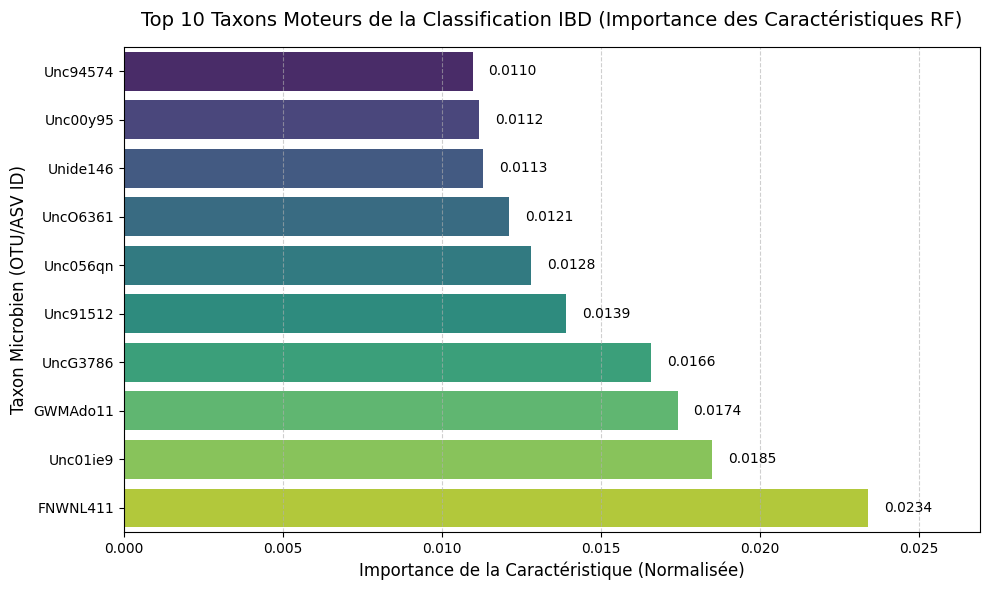

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Assurez-vous que top_10_taxa est le DataFrame calculé dans la Section 5 ---
df_plot = top_10_taxa.copy()

# Préparation pour le graphique : Trier par importance croissante pour que la plus importante soit en haut
df_plot = df_plot.sort_values(by='Importance', ascending=True).reset_index(drop=True)

# Création du graphique à barres
plt.figure(figsize=(10, 6))

# Utilisation de la méthode barplot de seaborn
sns.barplot(x='Importance', y='Taxon', data=df_plot, palette='viridis')

# Ajout de titres et labels
plt.title('Top 10 Taxons Moteurs de la Classification IBD (Importance des Caractéristiques RF)', fontsize=14, pad=15)
plt.xlabel('Importance de la Caractéristique (Normalisée)', fontsize=12)
plt.ylabel('Taxon Microbien (OTU/ASV ID)', fontsize=12)

# Affichage des valeurs exactes sur les barres (pour plus de précision)
for i, (taxon, importance) in enumerate(zip(df_plot['Taxon'], df_plot['Importance'])):
    # Positionnement du texte légèrement après la fin de la barre
    plt.text(importance + 0.0005, i, f'{importance:.4f}',
             color='black', ha="left", va="center", fontsize=10)

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xlim(0, df_plot['Importance'].max() * 1.15) # Ajuster la limite X pour le texte
plt.tight_layout()

# --- ÉTAPE CRUCIALE : SAUVEGARDE POUR L'ARTICLE LATEX ---
figure_path = 'feature_importance_top10.png'
# Utilisez dpi=300 pour une bonne résolution
# bbox_inches='tight' assure qu'aucun label n'est coupé
plt.savefig(figure_path, dpi=300, bbox_inches='tight')
print(f"\nFigure sauvegardée sous: {figure_path}")

# --- ÉTAPE CRUCIALE : AFFICHAGE DANS LE NOTEBOOK ---
plt.show()